# Metrics 

### Setup imports, qrels files and query URL's

In [22]:
# SETUP
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
import numpy as np
import json
import requests
import pandas as pd


QRELS_FILE_1 = "qrels/qrel1.txt" # USA tracks
QRELS_FILE_2 = "qrels/qrel2.txt" # Driver surenames ending in "son"
QRELS_FILE_3 = "qrels/qrel3.txt" # German drivers


# Queries
# Tracks in the USA using semantic search
# no url, just call get_embeddings.py

# Driver surnames ending in "son"
QUERY_URL_2 = "http://localhost:8983/solr/drivers/select?indent=true&q.op=OR&q=surname%3A*son&rows=32&useParams="

# German and Driver separated by at most 4 words
QUERY_URL_3 = "TODO:"

#TODO: Make new queries and organize them in a dictionary or list or tuples
# Drivers whare born in or after 1990
# QUERY_URL_2 = ""

querys_dict = {
    'query2': [QRELS_FILE_2, QUERY_URL_2, 'surname'],
    'query3': [QRELS_FILE_3, QUERY_URL_3, 'driver_bio'],
}

query = 'query2'

# Read qrels to extract relevant documents
relevant = list(map(lambda el: el.strip(), open(querys_dict[query][0], encoding="utf-8").readlines()))

# Get query results from Solr instance
results = requests.get(querys_dict[query][1]).json()["response"]["docs"]

print(results)

# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

[{'driverId': 19, 'driverRef': 'davidson', 'code': 'DAV', 'forename': 'Anthony', 'surname': 'Davidson', 'dateOfBirth': '1979-04-18T00:00:00Z', 'nationality': 'British', 'url': 'http://en.wikipedia.org/wiki/Anthony_Davidson', 'driver_bio': 'Anthony Denis Davidson (born 18 April 1979) is a British former racing driver, currently working as an analyst for the Sky Sports F1 television channel, as part of the commentary team for WEC TV, as colour commentator for the F1 series of video games, and as simulator and demonstration driver for Mercedes AMG Petronas. He is best known for racing in Formula One for Minardi and Super Aguri, and has been a test or reserve driver for the British American Racing, Honda, and Brawn GP teams. Davidson was the 2014 WEC World Champion, alongside his teammate, Sébastien Buemi.', 'id': '3817f016-8d6d-4bb5-8eb8-77f6638f3786', '_version_': 1784548641287962624}, {'driverId': 51, 'driverRef': 'wilson', 'forename': 'Justin', 'surname': 'Wilson', 'dateOfBirth': '1978

### Precision metric

In [23]:
@metric
def ap(results, relevant):
    """Average Precision"""
    precision_values = []
    relevant_count = 0
    
    for idx, doc in enumerate(results):
        if doc[querys_dict[query][2]] in relevant:
            relevant_count += 1
            precision_at_k = relevant_count / (idx + 1)
            precision_values.append(precision_at_k)

    if not precision_values:
        return 0.0

    return sum(precision_values)/len(precision_values)

### Precision at 10 metric

In [24]:
@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc[querys_dict[query][2]] in relevant])/n

In [25]:
@metric
def p5(results, relevant, n=5):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc[querys_dict[query][2]] in relevant])/n

### Main function to calculate metrics

In [26]:
def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

# Calculate all metrics and export results as LaTeX table
df = pd.DataFrame([['Metric','Value']] +
    [
        [evaluation_metrics[m], calculate_metric(m, results, relevant)]
        for m in evaluation_metrics
    ]
)

with open('results_2.tex','w') as tf:
    tf.write(df.style.to_latex())

### Precision-Recall metric

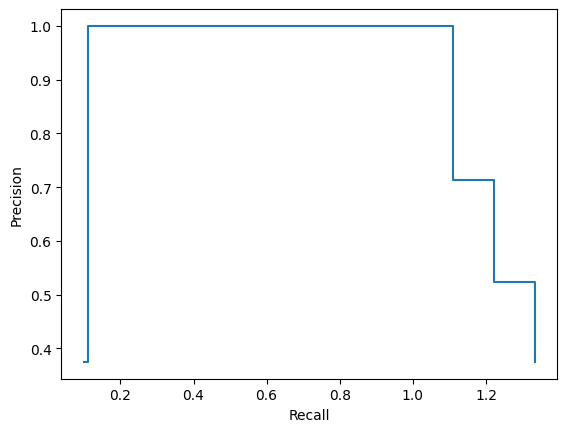

In [27]:
# PRECISION-RECALL CURVE
# Calculate precision and recall values as we move down the ranked list
precision_values = [
    len([
        doc 
        for doc in results[:idx]
        if doc[querys_dict[query][2]] in relevant
    ]) / idx 
    for idx, _ in enumerate(results, start=1)
]

recall_values = [
    len([
        doc for doc in results[:idx]
        if doc[querys_dict[query][2]] in relevant
    ]) / len(relevant)
    for idx, _ in enumerate(results, start=1)
]

precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}

# Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
recall_values.extend([step for step in np.arange(0.1, 1.1, 0.1) if step not in recall_values])
recall_values = sorted(set(recall_values))

# Extend matching dict to include these new intermediate steps
for idx, step in enumerate(recall_values):
    if step not in precision_recall_match:
        if recall_values[idx-1] in precision_recall_match:
            precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
        else:
            precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]

disp = PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)
disp.plot()
plt.savefig('precision_recall_' + query + '.png')
